# <center>实验一 信用卡欺诈分析</center>
<center>金融学（互联网+金融）1602班 沈吉梅 20160756</center>

## 1. 数据导入

In [1]:
import pandas as pd
creditCardData = pd.read_csv("../input/creditcard.csv")
creditCardData.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2. 数据探索

In [2]:
print (u'实验一的数据集列数是：', len(creditCardData.columns))
creditCardData.describe()

实验一的数据集列数是： 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [3]:
creditCardData.isnull().any().sum()

0

数据没有缺失，包含如题目所述的2013年9月2天时间里的284807笔交易数据，题给数据采用PCA变换映射为V1，V2，...，V28 数值型属性，只有交易时间和金额这两个变量没有经过PCA变换。接下来分析一下各个属性之间是否还存在相关性。

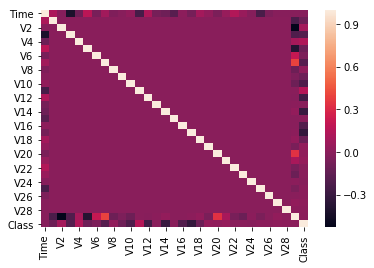

In [4]:
import seaborn as sns
sns.heatmap(creditCardData.corr())

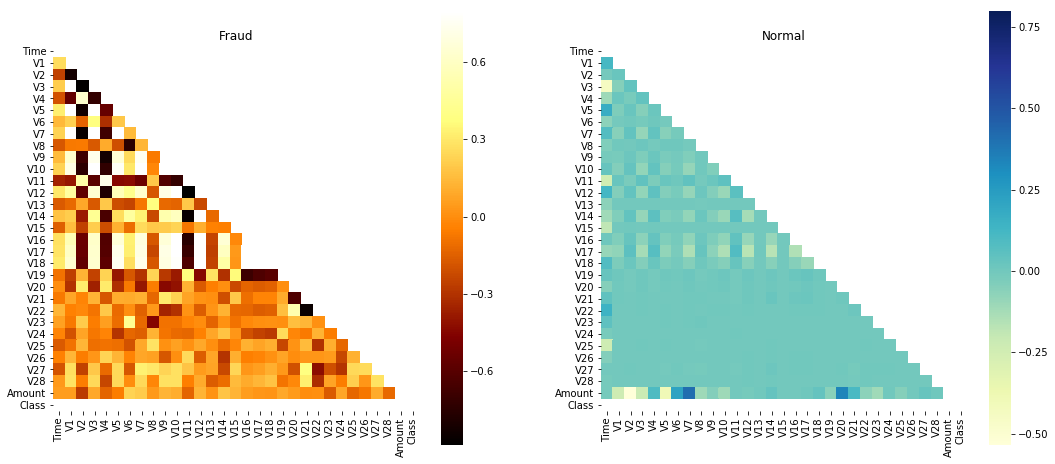

In [5]:
import matplotlib.pyplot as plt
import numpy as np
f, (ax1, ax2) = plt.subplots(1,2,figsize =( 18, 8))
corr = creditCardData.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap((creditCardData.loc[creditCardData['Class'] ==1]).corr(), vmax = .8, square=True, ax = ax1, cmap = 'afmhot', mask=mask);
ax1.set_title('Fraud')
sns.heatmap((creditCardData.loc[creditCardData['Class'] ==0]).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu', mask=mask);
ax2.set_title('Normal')
plt.show()

可以看出，28个属性完全无关。
接下来，分析一下我们的分类目标。

Text(0,0.5,'Frequency')

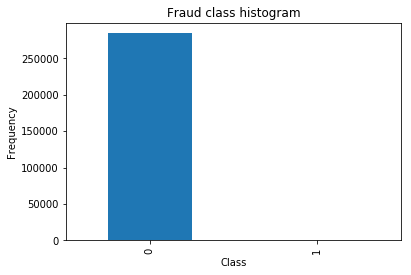

In [6]:
count_classes = pd.value_counts(creditCardData['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

我们看见，目标变量的分布极不平衡。

## 3. 不同的分类模型

<p>我的第六感告诉我时间和这个模型预测没啥关系，应该drop，但是不能拍脑门，就验证一下女生的第六感吧。</p>
<p>用的方法很navie（严肃脸）。</p>

In [7]:
# from sklearn.naive_bayes import GaussianNB
# from sklearn.metrics import accuracy_score
# col=list(creditCardData.columns.values)

In [8]:
# def split_data(dataset,ratio):
#     sample=np.random.rand(len(dataset))<ratio
#     return(dataset[sample],dataset[~sample])

In [9]:
# creditCardData['Log_Amount']=np.log(creditCardData['Amount']+1)

In [10]:
# def NB_Classify(ratio,drop_var):
#     print('drop:',drop_var)
#     pred_acc=[]
#     for i in range(10):
#         train,test=split_data(creditCardData,ratio)
#         clf=GaussianNB()
#         clf.fit(train.drop(drop_var,axis=1),train['Class'])
#         pred=clf.predict(test.drop(drop_var,axis=1))
#         pred_acc.append([pd.crosstab(test['Class'],pred).iloc[1,1]/(pd.crosstab(test['Class'],pred).iloc[1,0]+pd.crosstab(test['Class'],pred).iloc[1,1])])
#     print(np.mean(pred_acc))

In [11]:
# for var in col:
#     NB_Classify(0.6,['Class','Log_Amount',var])

结果很明显的了，要相信女生的第六感，时间没用了。接下来我们正经的分类了。其实通过上面的分析已经有了一个naive的结果，就是朴素贝叶斯可以达到0.8以上。

In [12]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score,auc,precision_recall_curve,roc_curve

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
def classification_eval(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)
    y_score = estimator.decision_function(X_test) 
    dec = np.int64(np.ceil(np.log10(len(y_test))))
    
    def plot_roc():
        fpr, tpr, t = roc_curve(y_test, y_score)
        plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
        plt.plot([0,1],[0,1], 'k--', linewidth = 2)
        plt.xlim([0.0,0.001])
        plt.ylim([0.0,1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (AUC=%0.2f)'% auc(fpr,tpr))
        plt.show();
    
    def plot_precision_recall():
        precision, recall, thresholds = precision_recall_curve(y_test, y_score)
        plt.step(recall, precision, color = 'b', alpha = 0.2,where = 'post')
        plt.fill_between(recall, precision, step ='post', alpha = 0.2,color = 'b')
        plt.plot(recall, precision, linewidth=2)
        plt.xlim([0.0,1])
        plt.ylim([0.0,1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve')
        plt.show();

    print('CONFUSION MATRIX')
    cfm=confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cfm, classes = range(2)) 
    plt.show()
    print('CLASSIFICATION REPORT')
    print(classification_report(y_test, y_pred, digits=dec))
    print('SCALAR METRICS')
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('MCC', matthews_corrcoef(y_test, y_pred)))
    print(format_str % ("Cohen's kappa", cohen_kappa_score(y_test, y_pred)))
    print(format_str % ('Accuracy', accuracy_score(y_test, y_pred)))
    plot_roc()
    plot_precision_recall()

In [15]:
def classification_eval1(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)
    y_score = estimator.predict_proba(X_test)[:,1]
    dec = np.int64(np.ceil(np.log10(len(y_test))))
    
    def plot_roc():
        fpr, tpr, t = roc_curve(y_test, y_score)
        plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
        plt.plot([0,1],[0,1], 'k--', linewidth = 2)
        plt.xlim([0.0,0.001])
        plt.ylim([0.0,1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (AUC=%0.2f)'% auc(fpr,tpr))
        plt.show();
    
    def plot_precision_recall():
        precision, recall, thresholds = precision_recall_curve(y_test, y_score)
        plt.step(recall, precision, color = 'b', alpha = 0.2,where = 'post')
        plt.fill_between(recall, precision, step ='post', alpha = 0.2,color = 'b')
        plt.plot(recall, precision, linewidth=2)
        plt.xlim([0.0,1])
        plt.ylim([0.0,1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve')
        plt.show();

    print('CONFUSION MATRIX')
    cfm=confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cfm, classes = range(2)) 
    plt.show()
    print('CLASSIFICATION REPORT')
    print(classification_report(y_test, y_pred, digits=dec))
    print('SCALAR METRICS')
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('MCC', matthews_corrcoef(y_test, y_pred)))
    print(format_str % ("Cohen's kappa", cohen_kappa_score(y_test, y_pred)))
    print(format_str % ('Accuracy', accuracy_score(y_test, y_pred)))
    plot_roc()
    plot_precision_recall()

### （1）SGD
本质上说，这个模型也是一个线性核函数的模型，不同的地方是，它使用了随机梯度下降做训练，所以每次并没有使用全部的样本，收敛速度会快很多。再多提一点，SGDClassifier对于特征的幅度非常敏感，也就是说，我们在把数据灌给它之前，应该先对特征做幅度调整，当然，用sklearn的StandardScaler可以很方便地完成这一点。

In [16]:
from sklearn.preprocessing import StandardScaler
creditCardData['normAmount'] = StandardScaler().fit_transform(creditCardData['Amount'].values.reshape(-1, 1))
creditCardData = creditCardData.drop(['Time','Amount'],axis=1)
creditCardData.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [17]:
from sklearn.model_selection import train_test_split
X = creditCardData.iloc[:, creditCardData.columns != 'Class']
y = creditCardData.iloc[:, creditCardData.columns == 'Class']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

In [18]:
X_train.shape

(199364, 29)

In [19]:
X_test.shape

(85443, 29)

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

In [21]:
param_grid_LR = [{
    'model__loss': ['log'],
    'model__penalty': ['l1', 'l2'],
    'model__alpha': np.logspace(start=-3, stop=3, num=20)
}]

In [22]:
param_grid_SVM={
    'model__loss': ['hinge'],
    'model__alpha': np.logspace(start=-3, stop=3, num=20),
    'model__class_weight': [None, 'balanced']
}

In [23]:
pipeline_sgd = Pipeline([
    ('scaler', StandardScaler(copy=False)),
    ('model', SGDClassifier(max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef

In [25]:
MCC_scorer = make_scorer(matthews_corrcoef)
LR = GridSearchCV(estimator=pipeline_sgd, param_grid=param_grid_LR, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)
SVM = GridSearchCV(estimator=pipeline_sgd, param_grid=param_grid_SVM, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [26]:
LR.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('model', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='opti...dom_state=1, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=True))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'model__loss': ['log'], 'model__penalty': ['l1', 'l2'], 'model__alpha': array([1.00000e-03, 2.06914e-03, 4.28133e-03, 8.85867e-03, 1.83298e-02,
       3.79269e-02, 7.84760e-02, 1.62378e-01, 3.35982e-01, 6.95193e-01,
       1.43845e+00, 2.97635e+00, 6.15848e+00, 1.27427e+01, 2.63665e+01,
       5.45559e+01, 1.12884e+02, 2.33572e+02, 4.83293e+02, 1.00000e+03])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=make_scorer(matthews

CONFUSION MATRIX


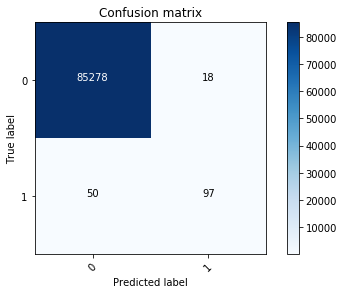

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0    0.99941   0.99979   0.99960     85296
           1    0.84348   0.65986   0.74046       147

   micro avg    0.99920   0.99920   0.99920     85443
   macro avg    0.92145   0.82983   0.87003     85443
weighted avg    0.99915   0.99920   0.99916     85443

SCALAR METRICS
          MCC = 0.74567
Cohen's kappa = 0.74007
     Accuracy = 0.99920


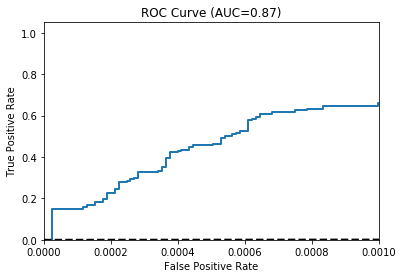

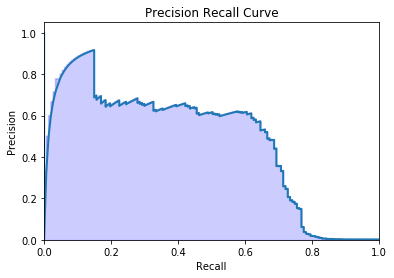

In [27]:
classification_eval(LR, X_test, y_test)

In [28]:
SVM.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.0min finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=False, with_mean=True, with_std=True)), ('model', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='opti...dom_state=1, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=True))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__loss': ['hinge'], 'model__alpha': array([1.00000e-03, 2.06914e-03, 4.28133e-03, 8.85867e-03, 1.83298e-02,
       3.79269e-02, 7.84760e-02, 1.62378e-01, 3.35982e-01, 6.95193e-01,
       1.43845e+00, 2.97635e+00, 6.15848e+00, 1.27427e+01, 2.63665e+01,
       5.45559e+01, 1.12884e+02, 2.33572e+02, 4.83293e+02, 1.00000e+03]), 'model__class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=make_scor

CONFUSION MATRIX


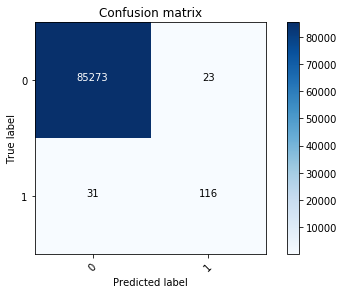

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0    0.99964   0.99973   0.99968     85296
           1    0.83453   0.78912   0.81119       147

   micro avg    0.99937   0.99937   0.99937     85443
   macro avg    0.91708   0.89442   0.90544     85443
weighted avg    0.99935   0.99937   0.99936     85443

SCALAR METRICS
          MCC = 0.81119
Cohen's kappa = 0.81087
     Accuracy = 0.99937


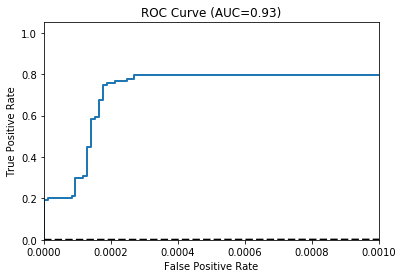

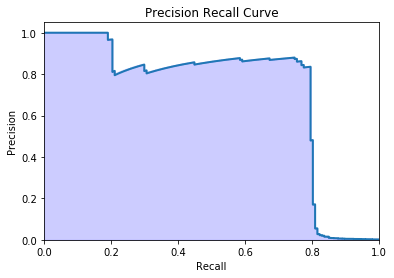

In [29]:
classification_eval(SVM, X_test, y_test)

### （2） Decision Tree Classifier
这似乎是我们目前为止唯一学过的分类器了，好像得用一下？试探一下

In [30]:
from sklearn.tree import DecisionTreeClassifier

先试探一下模型参数

In [31]:
deep=np.array(range(1,20))
xvalMSE =[]
score_hist=[]
for ideep in deep:
    dt=DecisionTreeClassifier(max_depth = ideep)
    dt.fit(X_train,y_train)
    pred=dt.predict(X_test)
    pred=np.array(pred,dtype=np.float32)
    y_tst=np.array(y_test,dtype=np.float32)
    error=[y_tst[r] - pred[r] for r in range(len(y_tst))]
    o_error=sum(e*e for e in error)
    mse=o_error/len(y_test)
    print(mse)
    xvalMSE.append(mse)

[0.00119378]
[0.00071393]
[0.00072563]
[0.0006437]
[0.0006203]
[0.00067882]
[0.00084267]
[0.00098311]
[0.00173215]
[0.00230563]
[0.00223541]
[0.00163852]
[0.00121719]
[0.00216519]
[0.00208326]
[0.00102993]
[0.00232904]
[0.00265674]
[0.00143956]


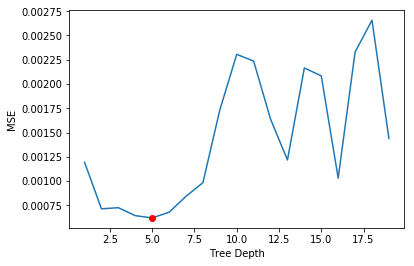

In [32]:
plt.figure()
plt.plot(deep,xvalMSE)
plt.xlabel("Tree Depth")
plt.ylabel("MSE")
opt_depth = deep[np.argmin(xvalMSE)]
plt.plot(opt_depth,np.amin(xvalMSE),"or")

In [33]:
print(opt_depth)

5


In [34]:
pipeline_dt = Pipeline([
    ('model', DecisionTreeClassifier(max_depth = opt_depth))
])

In [35]:
param_grid_dt = {}

In [36]:
dt = GridSearchCV(estimator=pipeline_dt, param_grid=param_grid_dt, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [37]:
dt.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('model', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=make_scorer(matthews_corrcoef), verbose=1)

CONFUSION MATRIX


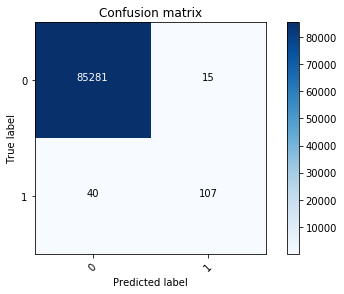

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0    0.99953   0.99982   0.99968     85296
           1    0.87705   0.72789   0.79554       147

   micro avg    0.99936   0.99936   0.99936     85443
   macro avg    0.93829   0.86386   0.89761     85443
weighted avg    0.99932   0.99936   0.99933     85443

SCALAR METRICS
          MCC = 0.79869
Cohen's kappa = 0.79522
     Accuracy = 0.99936


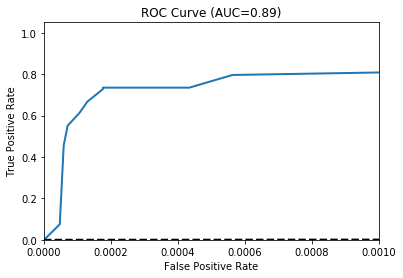

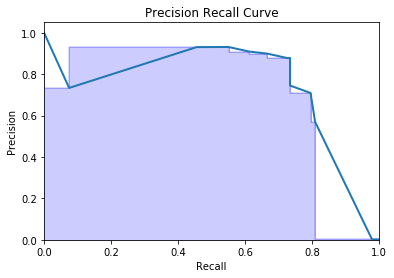

In [38]:
classification_eval1(dt, X_test, y_test)

emmmmm...一棵树可能不够用，接着我们请出一堆树

### （3）Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])

In [41]:
param_grid_rf = {'model__n_estimators': [75]}

In [42]:
rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)

In [43]:
rf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished
/opt/conda/lib/python3.6/site-packages/sklearn/pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__n_estimators': [75]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=False,
       scoring=make_scorer(matthews_corrcoef), verbose=1)

CONFUSION MATRIX


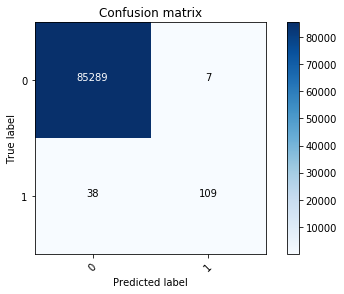

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0    0.99955   0.99992   0.99974     85296
           1    0.93966   0.74150   0.82890       147

   micro avg    0.99947   0.99947   0.99947     85443
   macro avg    0.96960   0.87071   0.91432     85443
weighted avg    0.99945   0.99947   0.99944     85443

SCALAR METRICS
          MCC = 0.83447
Cohen's kappa = 0.82864
     Accuracy = 0.99947


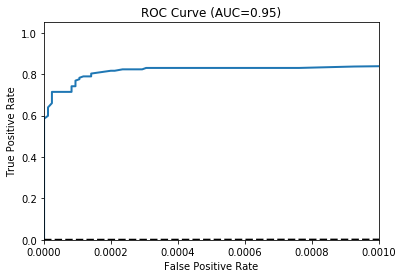

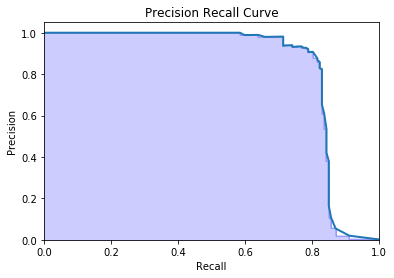

In [44]:
classification_eval1(rf, X_test, y_test)

### （4）NN
老师提了就试试，不过我能力有限，水平一般。

In [45]:
# creditCardData = pd.read_csv('../input/creditcard.csv')

In [46]:
# from sklearn.preprocessing import StandardScaler
# creditCardData['normAmount'] = StandardScaler().fit_transform(creditCardData['Amount'].values.reshape(-1, 1))
# creditCardData = creditCardData.drop(['Time','Amount'],axis=1)
# creditCardData.head()

In [47]:
# X = creditCardData.iloc[:, creditCardData.columns != 'Class']
# y = creditCardData.iloc[:, creditCardData.columns == 'Class']

In [48]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [49]:
# print(np.shape(X_train))
# print(np.shape(y_train))
# print(np.shape(X_test))
# print(np.shape(y_test))

In [50]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# from keras.utils import to_categorical

In [51]:
# NN = Sequential()
# NN.add(Dense(units=9,kernel_initializer='uniform',activation='relu',input_dim=29))
# NN.add(Dropout(rate=0.1))
# NN.add(Dense(units=9,kernel_initializer='uniform',activation='relu',input_dim=29))
# NN.add(Dropout(rate=0.1))
# NN.add(Dense(units=1,kernel_initializer='uniform',activation='sigmoid'))
# NN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [52]:
# NN.fit(X_train,y_train,batch_size=10,epochs=5)

In [53]:
# score, acc = NN.evaluate(X_test, y_test)
# print('Test score:', score)
# print('Test accuracy:', acc)

In [54]:
# history = NN.fit(X_train, y_train, batch_size = 2048, epochs = 20, 
#          validation_data = (X_test, y_test), verbose = 2)

In [55]:
# classification_eval(rf, X_test, y_test)